# Summary

Data Scientist: Jason Whittle Ph.D.

### EDA

The main thing that stood out to me in my initial inspection of the data were strange zeros in BP, BMI, insulin_test, and cardio_test. I assume that null/bad testing resulted in zero values or we are taking vitals on dead people. 

The prediction data set, although small, seemed to have different distributions in some key areas like the liver test and years of smoking. This alone isn't that interesting but it is important to note since we might see a different distribution of zeta disease in the prediction data set than the training if there are real differences in these two populations. Some of these differences were the result of the null/bad data problems, others were not and remained different between the data sets. 

### Strategies for dealing with data issues

For BP and BMI there were few missing values and so I just went with a quick mean imputation. If this were a longer term project I would probably model BMI since weight and age are probably highly predictive of bmi. 

For the missing insulin and cardio test there were too many to not model them with at least linear regression. Dropping them is not ideal for several reasons:
1. It would result in a near halving of an already fairly small data set. 
2. The prediction data set did not seem to have these data quality issues, so if there is information content in the features we should try to use them. 

### Feature engineering

I thought it was reasonable to suspect that a lot of these variables might have stronger interaction effects or non-linear relationships. While I generally push for flexible models that can handle that type of data such as tree based models as opposed to logistic regressions (where you have to manually interact variables), I created a few manually interacted variables. I did this because with a data set so small I have concerns about overfitting, which means I am going to restrict my tree based models. Adding in the interactions myself allows me to keep shallow depths for the tree models and still capture some of the more complex relationships.  

What I would've liked to on this if it were a real world project would be to do a much larger feature selection process. Creating a grid of terms to interact and then limiting the number of features in the model. This might have allowed more restrictive models like a logistic regression to display better AUC and Recall than it did.  

### Initial testing

I started with a basic train/test split. This is fast to set up and easy to iterate through features and basic parameters. This allowed me to find that XGB and logistic regression were not working for this data set. XGB I believe needs more data and was easily overfitting (having near perfect recall on the training set with poor recall on test set). Logistic regression was struggling with some of the non-linear relationships. 

SVC and Cart were the two models that were producing the best test set metrics. These two models were passed to a 5-fold CV grid search for some basic parameter tuning. With a data set so small there isn't much use doing an exhaustive grid search. SVM runs really slow for different kernel selections and Cart would likely overfit quickly if you allowed the depth to increase much. With a shallow decision tree there isn't much point in tuning parameters around leaf size etc. 

AUC and Recall were chosen as my metrics. AUC provides a good overall classifier quality metric. Even though I didn't see any indication of if Zeta was communicable or a serious disease I chose to err on the side of finding Zeta even if that meant more false positives, so I used recall as the models primary fitting metric. 


### Final model predictions

I choose an ensemble of CART and SVC looking for agreement between both models. I thought this might be a good balance of finding people with the illness vs flagging everyone. The models should be sensitive to zeta so I didn't feel that ensemble needed to be as well. This approach flagged 13 cases of Zeta out of the 20 subjects in the prediction data set. Seems high given the approx 34% zeta case rate in the train set. There were differences between the training and pred data though so it seems plausible. 

On a real world project I would like to see more test cases if possible and possibly add more models to the ensemble. I would also test and modify the ensemble method. I did not test the ensemble method using any sort of cross-validation so it is likely not ideal. 

## Final prections
Are located at the bottom of the notebook and are the furtherest right column of the pred_df dataframe. 


In [1]:
import sys
sys.path.append('.')
sys.path.append('..')
from src.notebook_header import * # numpy, pandas, plots
from src.eda_utils import * # reuseable useful plots

from statsmodels.stats.outliers_influence import variance_inflation_factor 

# processing
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.combine import SMOTETomek

# eval
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import fbeta_score

# models
from sklearn.linear_model import LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn import tree
from xgboost import XGBClassifier
from sklearn import svm

# tunning
from sklearn.model_selection import GridSearchCV


seed = 1999

In [2]:
# import data
train_df = pd.read_excel("../data/training_data.xlsx")
pred_df = pd.read_excel("../data/pred_data.xlsx")
pred_df = pred_df.drop('zeta_disease', axis=1)
train_df.shape, pred_df.shape, train_df.isnull().sum(), pred_df.isnull().sum()

((800, 9),
 (20, 8),
 age                   0
 weight                0
 bmi                   0
 blood_pressure        0
 insulin_test          0
 liver_stress_test     0
 cardio_stress_test    0
 years_smoking         0
 zeta_disease          0
 dtype: int64,
 age                   0
 weight                0
 bmi                   0
 blood_pressure        0
 insulin_test          0
 liver_stress_test     0
 cardio_stress_test    0
 years_smoking         0
 dtype: int64)

#### Data sets
- training sets are small. 
    - Careful with overfitting when using Tree based models. 
    - Careful with feature engineering. 

In [3]:
train_df.head(2)

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0


In [4]:
pred_df.head(2)

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking
0,24,151,39.5,69,72,1.3968,56,4
1,27,179,35.5,89,156,1.6608,43,6


In [5]:
## Basic data description
train_df.describe() # 35% prevalance of zeta in training data set

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,30.985000,172.407500,32.201625,69.565000,85.887500,0.544496,43.121250,4.051250,0.348750
std,13.824025,31.942438,8.549155,19.874784,126.333656,0.348711,30.409949,4.176173,0.476873
min,18.000000,94.000000,0.000000,0.000000,0.000000,0.140800,0.000000,0.000000,0.000000
25%,21.000000,149.000000,27.300000,62.000000,0.000000,0.307800,0.000000,1.000000,0.000000
50%,26.000000,167.000000,32.050000,72.000000,45.000000,0.445300,53.000000,3.000000,0.000000
75%,38.000000,192.000000,36.525000,80.000000,130.000000,0.699800,62.000000,6.000000,1.000000
max,109.000000,308.000000,86.100000,157.000000,1077.000000,3.481300,214.000000,40.000000,1.000000


#### Training set
- 35% prevalance of zeta in training data set. Probably don't need to up/down sample initially. 
- All features look like they have outliers. 
- no nulls but strange zeros, likely failed test/metrics result in 0 and need imputation. 0: bmi, bp, insulin, cardio
- scales will be problematic. consider tree models

In [6]:
pred_df.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,34.750000,178.800000,34.480000,78.500000,145.050000,1.569600,61.950000,6.050000
std,11.511436,27.935264,6.628773,14.005638,75.964309,0.230356,9.703363,3.471311
min,19.000000,120.000000,25.800000,59.000000,50.000000,1.249800,43.000000,2.000000
25%,26.250000,153.250000,30.250000,69.750000,76.250000,1.411800,55.750000,3.000000
50%,34.500000,188.500000,33.150000,72.500000,137.000000,1.483300,60.000000,5.500000
75%,44.250000,197.750000,37.600000,89.250000,167.750000,1.737800,68.000000,7.500000
max,60.000000,216.000000,50.700000,108.000000,362.000000,2.050800,83.000000,13.000000


#### Prediction set: 
- interestingly large visual differences in outliers and mean values of insulin_test, liver_stree_test, cardio_stress_test, years_smoking. The pred data set might have a very different distribution of Zeta than the train data. 
- might consider this for train/test spliting later. 
- no strange zeros

In [7]:
## correlations
# train_df.corr()

In [8]:
corr = train_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
age,1.000000,0.157705,0.035347,0.193066,-0.034294,0.042416,-0.106039,0.372373,0.192925
weight,0.157705,1.000000,0.214262,0.122349,0.304295,0.146779,0.053629,0.100834,0.471155
bmi,0.035347,0.214262,1.000000,0.240513,0.217265,0.116649,0.264861,0.028683,0.271856
blood_pressure,0.193066,0.122349,0.240513,1.000000,0.079425,0.045764,0.193221,0.095613,0.045739
insulin_test,-0.034294,0.304295,0.217265,0.079425,1.000000,0.175230,0.417894,-0.006292,0.126504
liver_stress_test,0.042416,0.146779,0.116649,0.045764,0.175230,1.000000,0.172048,0.021817,0.184738
cardio_stress_test,-0.106039,0.053629,0.264861,0.193221,0.417894,0.172048,1.000000,-0.080358,0.036090
years_smoking,0.372373,0.100834,0.028683,0.095613,-0.006292,0.021817,-0.080358,1.000000,0.195261
zeta_disease,0.192925,0.471155,0.271856,0.045739,0.126504,0.184738,0.036090,0.195261,1.000000


In [9]:
## VIF - training set
vif_data = pd.DataFrame() 
vif_data["feature"] = train_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(train_df.values, i) 
                          for i in range(len(train_df.columns))] 
vif_data

,feature,VIF
0,age,7.316571
1,weight,21.084411
2,bmi,16.244418
3,blood_pressure,14.410387
4,insulin_test,1.872418
5,liver_stress_test,3.649503
6,cardio_stress_test,4.014759
7,years_smoking,2.306157
8,zeta_disease,1.862225


In [10]:
# ## VIF - training set
# vif_data = pd.DataFrame() 
# vif_data["feature"] = train_df.columns 
  
# # calculating VIF for each feature 
# vif_data["VIF"] = [variance_inflation_factor(train_df.loc[train_df.insulin_test > 0].values, i) 
#                           for i in range(len(train_df.columns))] 
# vif_data

In [11]:
## VIF - training set
vif_data = pd.DataFrame() 
vif_data["feature"] = pred_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(pred_df.values, i) 
                          for i in range(len(pred_df.columns))] 
vif_data

,feature,VIF
0,age,20.986832
1,weight,59.810474
2,bmi,62.853442
3,blood_pressure,35.972884
4,insulin_test,8.510333
5,liver_stress_test,62.438971
6,cardio_stress_test,101.115896
7,years_smoking,6.935037


#### Pred data set: 
- high collinearity in some of the same areas as the training set, weight, bmi, bp. 
- a lot more indications of collinearity in some of tests: liver / cardio.

### Zeta vs no-zeta

In [12]:
def zeta_eda(df, feature:str, func:str):
    agg_mean = pd.NamedAgg(column=feature, aggfunc='mean')
    agg_med = pd.NamedAgg(column=feature, aggfunc=np.median)
    if feature == 'zeta_disease':
        return
    else: 
        print(f"### {feature} ###")
        print(df.groupby(['zeta_disease']).agg(mean = agg_mean, median = agg_med))

In [13]:
for i in train_df.columns:
    zeta_eda(train_df, i, 'mean')

### age ###
                   mean  median
zeta_disease                   
0             29.034549    24.0
1             34.627240    33.0
### weight ###
                    mean  median
zeta_disease                    
0             161.401152   157.0
1             192.960573   192.0
### bmi ###
                   mean  median
zeta_disease                   
0             30.501919    30.1
1             35.375627    34.2
### blood_pressure ###
                   mean  median
zeta_disease                   
0             68.900192    70.0
1             70.806452    74.0
### insulin_test ###
                    mean  median
zeta_disease                    
0              74.199616    45.0
1             107.713262    48.0
### liver_stress_test ###
                  mean  median
zeta_disease                  
0             0.497383  0.4038
1             0.632472  0.5178
### cardio_stress_test ###
                   mean  median
zeta_disease                   
0             42.318618    5

## distributions

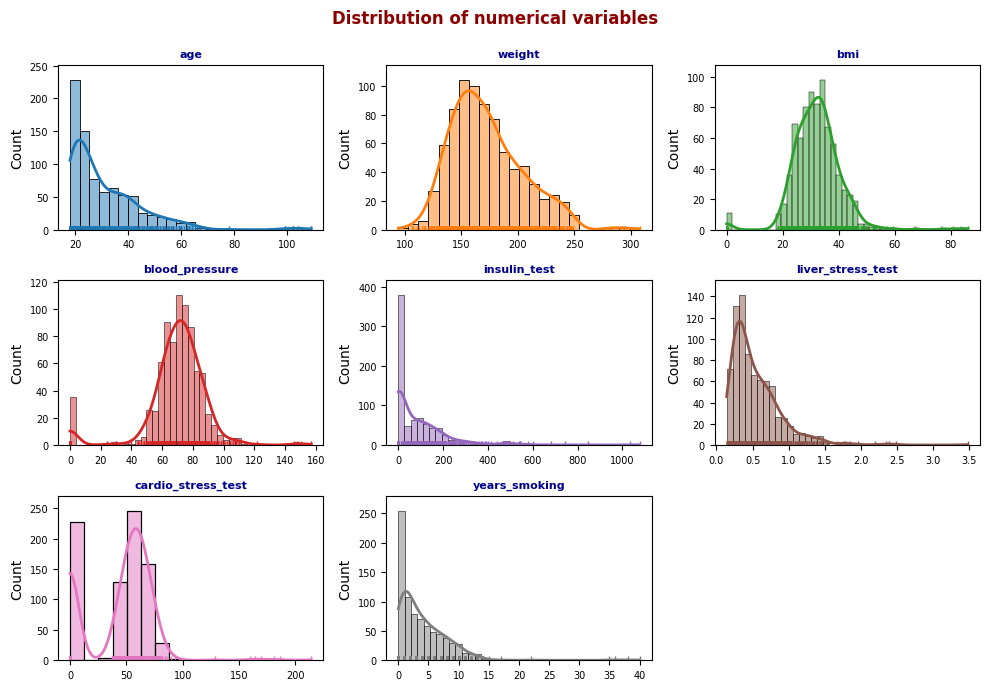

In [14]:
cols_to_plot = train_df.select_dtypes(include = ["float", "int"]).columns.to_list()
dist_plots(df=train_df, cols_to_plot=cols_to_plot, nrows=3, figsize_y=7)

strange zeros for cardio, bp, insulin. 

### Exploring strange zeros

In [15]:
print(train_df.loc[train_df.blood_pressure == 0].shape)
bp_df = train_df.loc[train_df.blood_pressure == 0]
bp_df.describe()

(35, 9)


,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,35.000000,35.000000,35.000000,35.0,35.0,35.000000,35.000000,35.000000,35.000000
mean,27.714286,167.800000,25.705714,0.0,0.0,0.451229,3.228571,3.628571,0.457143
std,9.820661,27.488821,14.874553,0.0,0.0,0.254266,13.333032,3.646801,0.505433
min,18.000000,123.000000,0.000000,0.0,0.0,0.164800,0.000000,0.000000,0.000000
25%,21.500000,147.500000,21.650000,0.0,0.0,0.260300,0.000000,0.000000,0.000000
50%,25.000000,167.000000,28.900000,0.0,0.0,0.344800,0.000000,2.000000,0.000000
75%,31.000000,183.500000,34.550000,0.0,0.0,0.636300,0.000000,6.000000,1.000000
max,69.000000,233.000000,52.300000,0.0,0.0,0.995800,60.000000,13.000000,1.000000


In [16]:
print(train_df.loc[train_df.cardio_stress_test == 0].shape)
cardio_df = train_df.loc[train_df.cardio_stress_test == 0]
cardio_df.describe()

(227, 9)


,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,227.000000,227.000000,227.000000,227.000000,227.0,227.000000,227.0,227.000000,227.000000
mean,34.251101,173.449339,30.129956,64.118943,0.0,0.456091,0.0,4.638767,0.387665
std,13.062933,29.572931,9.168249,28.839945,0.0,0.276871,0.0,3.350062,0.488294
min,18.000000,94.000000,0.000000,0.000000,0.0,0.140800,0.0,0.000000,0.000000
25%,24.000000,155.000000,25.150000,62.000000,0.0,0.265800,0.0,2.000000,0.000000
50%,31.000000,170.000000,30.400000,72.000000,0.0,0.344800,0.0,4.000000,0.000000
75%,42.000000,190.500000,35.050000,80.000000,0.0,0.599300,0.0,7.000000,1.000000
max,69.000000,247.000000,52.900000,122.000000,0.0,1.843800,0.0,13.000000,1.000000


In [17]:
print(train_df.loc[train_df.insulin_test == 0].shape)
insulin_df = train_df.loc[train_df.insulin_test == 0]
insulin_df.describe()

(370, 9)


,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,370.000000,370.000000,370.000000,370.000000,370.0,370.00000,370.000000,370.000000,370.000000
mean,32.854054,170.700000,30.908378,67.489189,0.0,0.47830,22.881081,4.445946,0.367568
std,12.754309,30.238604,8.432233,24.625348,0.0,0.30137,29.592662,3.445833,0.482796
min,18.000000,94.000000,0.000000,0.000000,0.0,0.14080,0.000000,0.000000,0.000000
25%,22.000000,150.250000,26.500000,64.000000,0.0,0.27180,0.000000,1.250000,0.000000
50%,29.000000,165.000000,31.200000,72.000000,0.0,0.36480,0.000000,4.000000,0.000000
75%,40.000000,188.000000,35.600000,80.000000,0.0,0.61605,55.750000,7.000000,1.000000
max,69.000000,249.000000,52.900000,122.000000,0.0,1.95580,129.000000,14.000000,1.000000


In [18]:
print(train_df.loc[train_df.bmi == 0].shape)
bmi_df = train_df.loc[train_df.bmi == 0]
bmi_df.describe()

(11, 9)


,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,11.000000,11.000000,11.0,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,27.454545,154.272727,0.0,28.818182,8.090909,0.496073,9.636364,3.909091,0.181818
std,15.945931,19.652435,0.0,40.651736,26.834510,0.460162,21.439556,3.505839,0.404520
min,18.000000,124.000000,0.0,0.000000,0.000000,0.164800,0.000000,0.000000,0.000000
25%,18.500000,139.000000,0.0,0.000000,0.000000,0.273300,0.000000,1.000000,0.000000
50%,21.000000,155.000000,0.0,0.000000,0.000000,0.323800,0.000000,3.000000,0.000000
75%,25.000000,166.500000,0.0,69.500000,0.000000,0.501300,0.000000,6.500000,0.000000
max,66.000000,186.000000,0.0,96.000000,89.000000,1.793800,53.000000,10.000000,1.000000


In [19]:
# dist_plots(df=train_df.loc[train_df.insulin_test >0], cols_to_plot=cols_to_plot, nrows=3, figsize_y=7)

In [20]:
train_df.loc[train_df.insulin_test > 0].shape

(430, 9)

In [21]:
train_df.zeta_disease.mean(), train_df.loc[train_df.insulin_test > 0].zeta_disease.mean()

(0.34875, 0.3325581395348837)

In [22]:
train_df.zeta_disease.sum(), train_df.loc[train_df.insulin_test > 0].zeta_disease.sum()

(279, 143)

In [23]:
train_df.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,30.985000,172.407500,32.201625,69.565000,85.887500,0.544496,43.121250,4.051250,0.348750
std,13.824025,31.942438,8.549155,19.874784,126.333656,0.348711,30.409949,4.176173,0.476873
min,18.000000,94.000000,0.000000,0.000000,0.000000,0.140800,0.000000,0.000000,0.000000
25%,21.000000,149.000000,27.300000,62.000000,0.000000,0.307800,0.000000,1.000000,0.000000
50%,26.000000,167.000000,32.050000,72.000000,45.000000,0.445300,53.000000,3.000000,0.000000
75%,38.000000,192.000000,36.525000,80.000000,130.000000,0.699800,62.000000,6.000000,1.000000
max,109.000000,308.000000,86.100000,157.000000,1077.000000,3.481300,214.000000,40.000000,1.000000


In [24]:
# train_df.loc[train_df.insulin_test > 0].describe()

In [25]:
pred_df.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,34.750000,178.800000,34.480000,78.500000,145.050000,1.569600,61.950000,6.050000
std,11.511436,27.935264,6.628773,14.005638,75.964309,0.230356,9.703363,3.471311
min,19.000000,120.000000,25.800000,59.000000,50.000000,1.249800,43.000000,2.000000
25%,26.250000,153.250000,30.250000,69.750000,76.250000,1.411800,55.750000,3.000000
50%,34.500000,188.500000,33.150000,72.500000,137.000000,1.483300,60.000000,5.500000
75%,44.250000,197.750000,37.600000,89.250000,167.750000,1.737800,68.000000,7.500000
max,60.000000,216.000000,50.700000,108.000000,362.000000,2.050800,83.000000,13.000000


In [26]:
# train_df.loc[(train_df.insulin_test > 0) & (train_df.bmi > 0) ].describe()

In [27]:
# cols_to_plot = pred_df.select_dtypes(include = ["float", "int"]).columns.to_list()
# dist_plots(df=pred_df, cols_to_plot=cols_to_plot, nrows=3, figsize_y=7)

# Strategy

Models to try: 
- logistic regression: less likely to overfit
- CART: to look at splits - Overfits
- XGB: Overfits - max_depth 2 - likely winner if kept in check 

Data issues
1. Try tree model and see if it partitions the zeros automatically. 
    - First try dropping insulin == 0 / flagging "bad_test".
2. Regression base imputation
    - mean imputation for bp/bmi since there are only 39 
    - Then regression based imputation for the bad tests based off age, weight, bmi, bp, liver_test, years_smoking
        - controlling for cummulative effects: age^2, years_smoking^2
3. center / scale - StandardScaler()



In [28]:
# train_df.head()

In [29]:
## Creating new features
train_df['age2'] = train_df['age'] * train_df['age']
train_df['smoke2'] = train_df['years_smoking'] * train_df['years_smoking']
# Note on age2, smoke2 - best confusion TP Cart result: 82.1, AUC 72

## simple imputation for features with few missing values. 
train_df['bmi'] = np.where(train_df['bmi']==0, train_df.bmi.mean(), train_df['bmi'])
train_df['blood_pressure'] = np.where(train_df['blood_pressure']==0, train_df.bmi.mean(), train_df['blood_pressure'])

# train_df['bmi2'] = train_df.bmi * train_df.bmi
# train_df['bmi_smoke'] = train_df.years_smoking * train_df.bmi 

# train_df['bp2'] = train_df.blood_pressure * train_df.blood_pressure
# svc no impact cart bad

# train_df['bp_smoke'] = train_df.blood_pressure * train_df.years_smoking
# Crt AUC:  0.7507  - Recall train:  0.9387  - Recall test:  0.8571

# train_df['bp_bmi'] = train_df.bmi * train_df.blood_pressure
# SVC AUC:  0.7109  - Recall train:  0.8582  - Recall test:  0.7679 not adding anything beyond


## removing primary target
y = train_df['zeta_disease']
X = train_df.drop('zeta_disease', axis=1)

In [30]:
# train_df.describe()

In [31]:
## cardio imputation 
cr_df = X.loc[train_df['cardio_stress_test']>0]
# droping other bad test
cr_df = cr_df.drop('insulin_test',axis=1)
print(cr_df.shape)

y_cr = cr_df['cardio_stress_test']
X_cr = cr_df.drop('cardio_stress_test', axis=1)

# scale
cr_scale = StandardScaler()
X_cr = cr_scale.fit_transform(X_cr)

# fit
cr_reg = LinearRegression().fit(X_cr, y_cr)
print("R2: ", cr_reg.score(X_cr, y_cr))

# scale full df
cr_pred_df = X.drop('insulin_test',axis=1)
cr_pred_df = cr_pred_df.drop('cardio_stress_test',axis=1)
cr_pred_df = cr_scale.fit_transform(cr_pred_df)
print(cr_pred_df.shape)

# predict
cr_preds = cr_reg.predict(cr_pred_df)
X['cardio_imp'] = pd.Series(cr_preds)
train_df['cardio_imp'] = pd.Series(cr_preds)
X['cardio_stress_test'] = np.where(X['cardio_stress_test']==0, X['cardio_imp'], X['cardio_stress_test'])
train_df['cardio_stress_test'] = np.where(train_df['cardio_stress_test']==0, train_df['cardio_imp'], train_df['cardio_stress_test'])
#train_df = train_df.drop('cardio_imp', axis=1)

(573, 9)
R2:  0.15253406389581403
(800, 8)


In [32]:
## insulin imputation
in_df = X.loc[X['insulin_test']>0]
print(in_df.shape)

y_in = in_df['insulin_test']
X_in = in_df.drop('insulin_test', axis=1)

# Scale in_df
in_scale = StandardScaler()
X_in = in_scale.fit_transform(X_in)
print(X_in.shape)

# fit
in_reg = LinearRegression().fit(X_in, y_in)
print("R2: ", in_reg.score(X_in, y_in))

# scale full df
in_pred_df = X.drop('insulin_test',axis=1)
in_pred_df = in_scale.fit_transform(in_pred_df)
print(in_pred_df.shape)

# predict
in_preds = in_reg.predict(in_pred_df)
train_df['insulin_imp'] = pd.Series(in_preds)
train_df['insulin_test'] = np.where(train_df['insulin_test']==0, train_df['insulin_imp'], train_df['insulin_test'])
#train_df = train_df.drop('insulin_imp', axis=1)

(430, 11)
(430, 10)
R2:  0.24868090302469192
(800, 10)


In [33]:
# train_df['bp_smoke'] = train_df.blood_pressure * train_df.years_smoking
# Crt AUC:  0.7507  - Recall train:  0.9387  - Recall test:  0.8571

train_df['cardio_smoke'] = train_df.cardio_stress_test * train_df.years_smoking # * 

# # train_df['cardio_stress_test_2'] = train_df.cardio_stress_test * train_df.cardio_stress_test
# # SVC AUC:  0.7067  - Recall train:  0.841  - Recall test:  0.75
# # bad for cart, with cardio_smoke bad for SVC

train_df['cardio_bmi'] = train_df.cardio_stress_test * train_df.bmi # * 
# # Crt AUC:  0.7328  - Recall train:  0.9351  - Recall test:  0.8214
# # SVC AUC:  0.7157  - Recall train:  0.8597  - Recall test:  0.7679

# # train_df['insulin_smoke'] = train_df.insulin_test * train_df.years_smoking
# # train_df['insulin_2'] = train_df.insulin_test * train_df.insulin_test

train_df['insulin_bmi'] = train_df.insulin_test * train_df.bmi # *
# #Crt AUC:  0.7287  - Recall train:  0.9093  - Recall test:  0.8036

# # train_df['in_car'] = train_df.insulin_test * train_df.cardio_stress_test 

In [34]:
# train_df.head(2)

In [35]:
# train_df.describe()

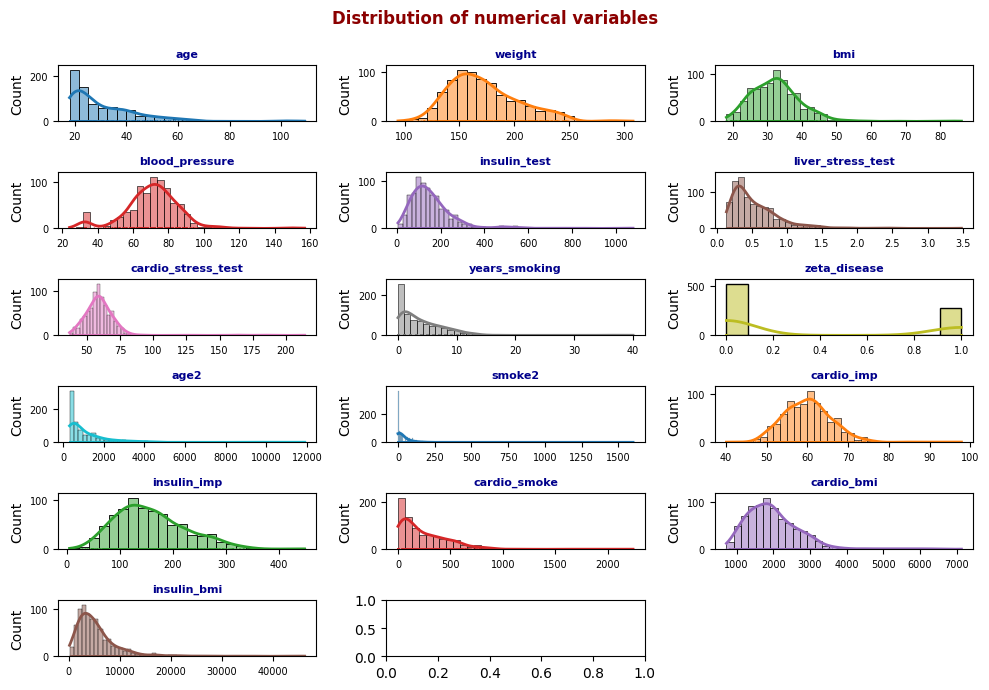

In [36]:
cols_to_plot = train_df.select_dtypes(include = ["float", "int"]).columns.to_list()
dist_plots(df=train_df, cols_to_plot=cols_to_plot, nrows=6, figsize_y=7)

In [37]:
train_df = train_df.drop('insulin_imp', axis=1)
train_df = train_df.drop('cardio_imp', axis=1)

In [63]:
train_df.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease,age2,smoke2,cardio_smoke,cardio_bmi,insulin_bmi
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,30.985000,172.407500,32.644397,70.993192,157.415406,0.544496,60.043210,4.051250,0.348750,1150.935000,33.831250,243.446624,2002.669428,5367.699720
std,13.824025,31.942438,7.656103,15.514267,107.051468,0.348711,13.999657,4.176173,0.476873,1306.015922,105.531222,245.494631,782.243432,4435.347186
min,18.000000,94.000000,18.200000,24.000000,5.583368,0.140800,37.000000,0.000000,0.000000,324.000000,0.000000,0.000000,725.200000,139.584203
25%,21.000000,149.000000,27.500000,62.000000,93.873840,0.307800,53.000000,1.000000,0.000000,441.000000,1.000000,60.000000,1455.000000,2700.656951
50%,26.000000,167.000000,32.201625,72.000000,135.000000,0.445300,59.000000,3.000000,0.000000,676.000000,9.000000,168.000000,1890.133197,4362.306071
75%,38.000000,192.000000,36.525000,80.000000,191.673314,0.699800,65.000000,6.000000,1.000000,1444.000000,36.000000,371.902577,2387.000000,6505.461103
max,109.000000,308.000000,86.100000,157.000000,1077.000000,3.481300,214.000000,40.000000,1.000000,11881.000000,1600.000000,2240.000000,7126.200000,46203.300000


In [64]:
pred_df.describe()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,age2,smoke2,cardio_smoke,cardio_bmi,insulin_bmi,cart,svc,zeta_pred
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000
mean,34.750000,178.800000,34.480000,78.500000,145.050000,1.569600,61.950000,6.050000,1333.450000,48.050000,373.350000,2171.100000,5074.980000,0.700000,0.800000,0.65000
std,11.511436,27.935264,6.628773,14.005638,75.964309,0.230356,9.703363,3.471311,869.012475,51.736656,220.925154,712.905891,2969.591789,0.470162,0.410391,0.48936
min,19.000000,120.000000,25.800000,59.000000,50.000000,1.249800,43.000000,2.000000,361.000000,4.000000,106.000000,1290.000000,1702.800000,0.000000,0.000000,0.00000
25%,26.250000,153.250000,30.250000,69.750000,76.250000,1.411800,55.750000,3.000000,690.750000,9.000000,219.000000,1817.875000,2917.050000,0.000000,1.000000,0.00000
50%,34.500000,188.500000,33.150000,72.500000,137.000000,1.483300,60.000000,5.500000,1190.500000,30.500000,315.000000,1992.150000,4540.200000,1.000000,1.000000,1.00000
75%,44.250000,197.750000,37.600000,89.250000,167.750000,1.737800,68.000000,7.500000,1958.250000,57.000000,456.000000,2308.400000,5759.150000,1.000000,1.000000,1.00000
max,60.000000,216.000000,50.700000,108.000000,362.000000,2.050800,83.000000,13.000000,3600.000000,169.000000,936.000000,4208.100000,11684.400000,1.000000,1.000000,1.00000


In [38]:
corr = train_df.loc[train_df.insulin_test > 0].corr()
corr.style.background_gradient(cmap='coolwarm')

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease,age2,smoke2,cardio_smoke,cardio_bmi,insulin_bmi
age,1.000000,0.157705,0.024683,0.225523,0.132365,0.042416,0.085045,0.372373,0.192925,0.952498,0.170618,0.401618,0.053304,0.106867
weight,0.157705,1.000000,0.206380,0.143442,0.566237,0.146779,0.207878,0.100834,0.471155,0.093099,0.051441,0.143634,0.243208,0.519694
bmi,0.024683,0.206380,1.000000,0.185971,0.279717,0.122215,0.397903,0.030058,0.283297,-0.020419,0.006231,0.097795,0.833049,0.534875
blood_pressure,0.225523,0.143442,0.185971,1.000000,0.082379,0.033974,0.159700,0.113158,0.079545,0.168917,0.032964,0.148304,0.204665,0.116364
insulin_test,0.132365,0.566237,0.279717,0.082379,1.000000,0.127281,0.150048,0.051641,0.317053,0.076401,0.065289,0.074053,0.249879,0.932968
liver_stress_test,0.042416,0.146779,0.122215,0.033974,0.127281,1.000000,0.084436,0.021817,0.184738,0.034236,0.045448,0.019993,0.127569,0.126150
cardio_stress_test,0.085045,0.207878,0.397903,0.159700,0.150048,0.084436,1.000000,0.003366,0.225726,0.039914,-0.039189,0.197862,0.824783,0.223425
years_smoking,0.372373,0.100834,0.030058,0.113158,0.051641,0.021817,0.003366,1.000000,0.195261,0.249028,0.821412,0.964159,0.005343,0.037880
zeta_disease,0.192925,0.471155,0.283297,0.079545,0.317053,0.184738,0.225726,0.195261,1.000000,0.111672,0.102564,0.242313,0.294737,0.332937
age2,0.952498,0.093099,-0.020419,0.168917,0.076401,0.034236,0.039914,0.249028,0.111672,1.000000,0.114605,0.267801,0.003870,0.052965


In [39]:
## train / test
y = train_df['zeta_disease']
X = train_df.drop('zeta_disease', axis=1)

# train test split
X_train, X_test, y_train, y_test = tts(X,y, 
                                       test_size = 0.2, 
                                       random_state = seed, 
                                       shuffle = True, 
                                       stratify = y)

# Smote-tomek class balance
print(y_train.mean(), " | ", y_train.shape)
smt = SMOTETomek(random_state = seed)
X_train, y_train = smt.fit_resample(X_train, y_train)
print(y_train.mean(), " | ", y_train.shape)

# center-scale for SVM / Logit
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

0.3484375  |  (640,)
0.5  |  (782,)


In [40]:
lr = LogisticRegression(random_state = seed, class_weight="balanced")
cart = tree.DecisionTreeClassifier(random_state=seed,  max_depth=3, class_weight="balanced")
xgb = XGBClassifier(objective = "binary:logistic", max_depth=2, random_state = seed)#, scale_pos_weight=3)
svc = svm.SVC(class_weight="balanced", kernel ='rbf', C = 2, random_state = seed)

models = {'Lgt':lr, 
         'Crt':cart, 
         'XGB':xgb, 
         'SVC':svc
         }

In [41]:
# store AUC
auc_train = {}
auc_test = {}

# store the recall metric
recall_train = {}
recall_test = {}

# store the f2 metric
f2_train = {}
f2_test = {}

# store the confusion matrix
cf_matrix_train = {}
cf_matrix_test = {}

# store the accuracy metric
accuracy_train = {}
accuracy_test = {}

# store the classification report
clf_report_train = {}
clf_report_test = {}

In [42]:
# basic feature selection / eval
for model_name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # AUC score
    auc_train[model_name] = roc_auc_score(y_train, y_pred_train)
    auc_test[model_name]  = roc_auc_score(y_test, y_pred_test)
    # print(f" - {model_name} AUC: ", round(auc_test[model_name], 4))
    
    # Accuracy score
    accuracy_train[model_name] = accuracy_score(np.array(y_train), y_pred_train)
    accuracy_test[model_name] = accuracy_score(np.array(y_test), y_pred_test)
    
    # Recall score
    recall_train[model_name] = recall_score(np.array(y_train), y_pred_train)
    recall_test[model_name] = recall_score(np.array(y_test), y_pred_test)
    
    # F2 score
    f2_train[model_name] = fbeta_score(np.array(y_train), y_pred_train, beta = 2)
    f2_test[model_name] = fbeta_score(np.array(y_test), y_pred_test, beta = 2)
    
    # Confusion Matrix
    cf_matrix_train[model_name] = confusion_matrix(np.array(y_train), y_pred_train)
    cf_matrix_test[model_name] = confusion_matrix(np.array(y_test), y_pred_test)
    
    print(f" - {model_name} AUC: ", round(auc_test[model_name], 4),
        " - Recall train: ", round(recall_train[model_name], 4), 
        " - Recall test: ", round(recall_test[model_name], 4))

 - Lgt AUC:  0.6985  - Recall train:  0.798  - Recall test:  0.7143
 - Crt AUC:  0.7088  - Recall train:  0.8926  - Recall test:  0.8214
 - XGB AUC:  0.7026  - Recall train:  0.9719  - Recall test:  0.7321
 - SVC AUC:  0.7445  - Recall train:  0.9105  - Recall test:  0.7679


In [43]:
# train_df.columns

## Develop 2 choosen models

- CART and SVC are the two best models found from an AUC/Recall perspective. 
-  Run one last set of CV with selected features for each model and then predict.
- replicate engineer features in pred data set

SVC w/ smote-tomek: AUC:  0.7157  - Recall train:  0.8414  - Recall test:  0.7679
- ['age', 'weight', 'bmi', 'blood_pressure', 'insulin_test',
       'liver_stress_test', 'cardio_stress_test', 'years_smoking',
       'zeta_disease', 'age2', 'smoke2', 'cardio_smoke', 'cardio_bmi',
       'insulin_bmi']

CART w/ smote-tomek: AUC:  0.7507  - Recall train:  0.9387  - Recall test:  0.8571
- ['age', 'weight', 'bmi', 'blood_pressure', 'insulin_test',
       'liver_stress_test', 'cardio_stress_test', 'years_smoking',
       'zeta_disease', 'age2', 'smoke2', 'bp_smoke', 'cardio_smoke',
       'cardio_bmi', 'insulin_bmi']

In [44]:
# SVC
train_svc_cols = ['age', 'weight', 'bmi', 'blood_pressure', 'insulin_test',
       'liver_stress_test', 'cardio_stress_test', 'years_smoking',
       'zeta_disease', 'age2', 'smoke2', # 'bp_smoke', 
       'cardio_smoke', 'cardio_bmi', 'insulin_bmi']

train_svc = train_df[train_svc_cols]
train_svc.shape

print(train_svc.shape)
X_svc = train_svc.drop('zeta_disease', axis=1)
y_svc = train_svc['zeta_disease']
print(X_svc.shape, y_svc.shape)


# smote-tomek
print(y_svc.mean(), " | ", y_svc.shape)
smt_svc = SMOTETomek(random_state = seed)
X_svc, y_svc = smt_svc.fit_resample(X_svc, y_svc)
print(y_svc.mean(), " | ", y_svc.shape)
print(X_svc.columns)

# scaler
X_svc = std_scaler.transform(X_svc)

# basic grid search
parameters_svc = {'C':[1, 2, 3], 'kernel':( 'rbf', 'sigmoid')}

svc = svm.SVC(class_weight="balanced", random_state = seed)
clf_svc = GridSearchCV(svc, parameters_svc, scoring=['roc_auc', 'recall'], refit='recall', verbose = 1)

clf_svc.fit(X_svc, y_svc)

print("best params", clf_svc.best_params_)
print("best score", clf_svc.best_score_)

(800, 14)
(800, 13) (800,)
0.34875  |  (800,)
0.5  |  (970,)
Index(['age', 'weight', 'bmi', 'blood_pressure', 'insulin_test',
       'liver_stress_test', 'cardio_stress_test', 'years_smoking', 'age2',
       'smoke2', 'cardio_smoke', 'cardio_bmi', 'insulin_bmi'],
      dtype='object')
Fitting 5 folds for each of 6 candidates, totalling 30 fits
best params {'C': 2, 'kernel': 'rbf'}
best score 0.8762886597938145


In [45]:
clf_svc.cv_results_

{'mean_fit_time': array([0.02106242, 0.01837692, 0.02152691, 0.01724277, 0.02154369,
        0.01805196]),
 'std_fit_time': array([0.00081026, 0.00271445, 0.00076802, 0.00215338, 0.00065131,
        0.0038362 ]),
 'mean_score_time': array([0.01381621, 0.01147957, 0.01332021, 0.01073465, 0.01306977,
        0.01056933]),
 'std_score_time': array([0.00022976, 0.00103136, 0.00035672, 0.00056511, 0.00038879,
        0.00033564]),
 'param_C': masked_array(data=[1, 1, 2, 2, 3, 3],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'sigmoid', 'rbf', 'sigmoid', 'rbf', 'sigmoid'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'kernel': 'rbf'},
  {'C': 1, 'kernel': 'sigmoid'},
  {'C': 2, 'kernel': 'rbf'},
  {'C': 2, 'kernel': 'sigmoid'},
  {'C': 3, 'kernel': 'rbf'},
  {'C': 3, 'kernel': 'sigmoid'}],
 '

### SVC parameter thoughts
kernel 'rbf' and C = 2. 

In [46]:
# CART
train_cart_cols = ['age', 'weight', 'bmi', 'blood_pressure', 'insulin_test',
       'liver_stress_test', 'cardio_stress_test', 'years_smoking',
       'zeta_disease', 'age2', 'smoke2', #'bp_smoke', 
       'cardio_smoke', 'cardio_bmi', 'insulin_bmi']

train_cart = train_df[train_cart_cols]
train_cart.shape

print(train_cart.shape)
X_cart = train_cart.drop('zeta_disease', axis=1)
y_cart = train_cart['zeta_disease']
print(X_cart.shape, y_cart.shape)

# smote-tomek
print(y_cart.mean(), " | ", y_cart.shape)
smt_cart = SMOTETomek(random_state = seed)
X_cart, y_cart = smt_cart.fit_resample(X_cart, y_cart)
print(y_cart.mean(), " | ", y_cart.shape)
print(X_cart.columns)

# scaler? - no impact but just checking
X_cart = std_scaler.transform(X_cart)

# basic grid search
parameters_cart = {'max_depth':[2, 3, 4]}

cart = tree.DecisionTreeClassifier(random_state=seed, class_weight="balanced")
clf_cart = GridSearchCV(cart, parameters_cart, scoring=['roc_auc', 'recall'], refit='recall', verbose = 1)

clf_cart.fit(X_cart, y_cart)

print("best params", clf_cart.best_params_)
print("best score", clf_cart.best_score_)

(800, 14)
(800, 13) (800,)
0.34875  |  (800,)
0.5  |  (970,)
Index(['age', 'weight', 'bmi', 'blood_pressure', 'insulin_test',
       'liver_stress_test', 'cardio_stress_test', 'years_smoking', 'age2',
       'smoke2', 'cardio_smoke', 'cardio_bmi', 'insulin_bmi'],
      dtype='object')
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best params {'max_depth': 4}
best score 0.8618556701030927


In [47]:
clf_cart.cv_results_

{'mean_fit_time': array([0.00362015, 0.00438428, 0.00534801]),
 'std_fit_time': array([9.51345700e-05, 6.53470488e-05, 5.39836527e-05]),
 'mean_score_time': array([0.00455618, 0.00456529, 0.0046855 ]),
 'std_score_time': array([7.70632876e-05, 9.53675985e-05, 6.61824553e-05]),
 'param_max_depth': masked_array(data=[2, 3, 4],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2}, {'max_depth': 3}, {'max_depth': 4}],
 'split0_test_roc_auc': array([0.72319056, 0.73812307, 0.74662557]),
 'split1_test_roc_auc': array([0.79673717, 0.80024445, 0.80263577]),
 'split2_test_roc_auc': array([0.86853013, 0.8836752 , 0.89409076]),
 'split3_test_roc_auc': array([0.80922521, 0.84854926, 0.87671378]),
 'split4_test_roc_auc': array([0.83404187, 0.85460729, 0.82118185]),
 'mean_test_roc_auc': array([0.80634499, 0.82503986, 0.82824955]),
 'std_test_roc_auc': array([0.04826878, 0.05105755, 0.05301385]),
 'rank_test_roc_auc': array([3, 2,

### Cart Parmeters thoughts
Since max_depth 3 v 4 results are so close I am goint to use 3 out of overfitting concerns. I loss next to nothing in AUC and only a very small (probably not significant) amount in Recall. 

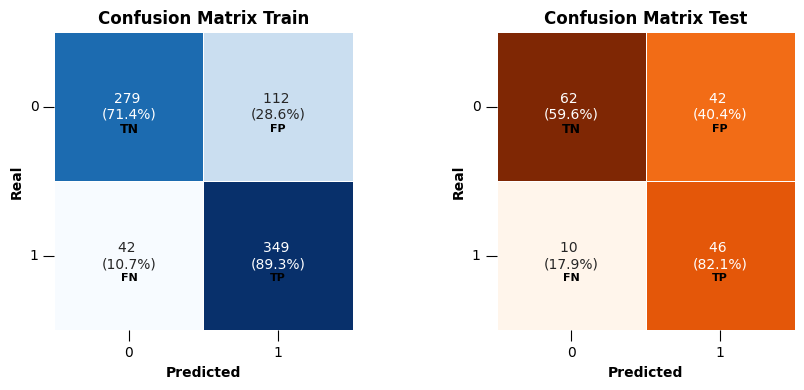

In [48]:
#================================= CART =========================
# using grid search parameters on original train/test split
confusion_matrix_plot(cf_matrix_train['Crt'],
                      cf_matrix_test['Crt'],
                      ["0","1"])

In [49]:
cart = tree.DecisionTreeClassifier(random_state=seed,  max_depth=3, class_weight="balanced")

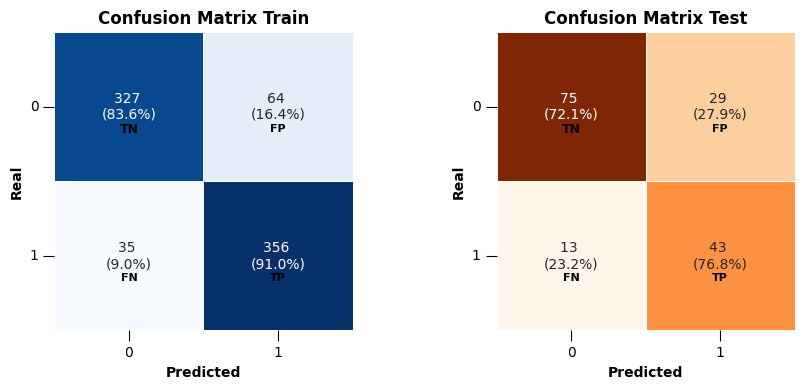

In [50]:
#================================= SVC =====================================
# using grid search parameters on train/test split
confusion_matrix_plot(cf_matrix_train['SVC'],
                      cf_matrix_test['SVC'],
                      ["0","1"])

In [51]:
svc = svm.SVC(class_weight="balanced", kernel ='rbf', C = 2, random_state = seed)

In [52]:
# fit on full training data
X_df = train_df.drop('zeta_disease', axis=1)
y_df = train_df['zeta_disease']

# smote-tomek
smt = SMOTETomek(random_state = seed)
X_df, y_df = smt.fit_resample(X_df, y_df)

# scale for SVM
scaler = StandardScaler()
X_df = scaler.fit_transform(X_df)

# fit final models
cart.fit(X_df, y_df)
svc.fit(X_df, y_df)

SVC(C=2, class_weight='balanced', random_state=1999)

## Ensemble prediciton

In [53]:
pred_df

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking
0,24,151,39.5,69,72,1.3968,56,4
1,27,179,35.5,89,156,1.6608,43,6
2,34,147,26.9,76,74,1.6958,53,2
3,35,206,32.4,73,127,1.4608,61,6
4,60,193,29.8,62,192,1.7798,65,9
5,45,120,36.5,108,50,1.2978,54,12
6,20,139,38.2,61,77,1.5818,68,3
7,23,137,31.2,70,73,1.4168,59,7
8,36,195,30.5,59,141,1.4498,59,6
9,19,193,25.8,84,66,1.7938,50,3


In [54]:
# creating needed features in pred_df
# ['age', 'weight', 'bmi', 'blood_pressure', 'insulin_test',
# 'liver_stress_test', 'cardio_stress_test', 'years_smoking', 'age2', 
# 'smoke2', 'cardio_smoke', 'cardio_bmi', 'insulin_bmi']

pred_df['age2'] = pred_df['age'] * pred_df['age']
pred_df['smoke2'] = pred_df['years_smoking'] * pred_df['years_smoking']
pred_df['cardio_smoke'] = pred_df.cardio_stress_test * pred_df.years_smoking 
pred_df['cardio_bmi'] = pred_df.cardio_stress_test * pred_df.bmi
pred_df['insulin_bmi'] = pred_df.insulin_test * pred_df.bmi

pred_df.columns

Index(['age', 'weight', 'bmi', 'blood_pressure', 'insulin_test',
       'liver_stress_test', 'cardio_stress_test', 'years_smoking', 'age2',
       'smoke2', 'cardio_smoke', 'cardio_bmi', 'insulin_bmi'],
      dtype='object')

In [55]:
pred_scale = scaler.transform(pred_df)

In [56]:
cart.predict_proba(pred_scale)

array([[0.95192308, 0.04807692],
       [0.36090226, 0.63909774],
       [0.85714286, 0.14285714],
       [0.46153846, 0.53846154],
       [0.36090226, 0.63909774],
       [0.85714286, 0.14285714],
       [0.95192308, 0.04807692],
       [0.95192308, 0.04807692],
       [0.46153846, 0.53846154],
       [0.95192308, 0.04807692],
       [0.0787037 , 0.9212963 ],
       [0.46153846, 0.53846154],
       [0.36090226, 0.63909774],
       [0.0787037 , 0.9212963 ],
       [0.36090226, 0.63909774],
       [0.46153846, 0.53846154],
       [0.36090226, 0.63909774],
       [0.0787037 , 0.9212963 ],
       [0.36363636, 0.63636364],
       [0.36090226, 0.63909774]])

In [57]:
cart.predict(pred_scale).sum()

14

In [58]:
svc.predict(pred_scale).sum()

16

In [59]:
train_df.groupby('zeta_disease').years_smoking.mean()

zeta_disease
0    3.454894
1    5.164875
Name: years_smoking, dtype: float64

In [60]:
pred_df['cart'] = cart.predict(pred_scale)
pred_df['svc'] = svc.predict(pred_scale)

In [61]:
pred_df['zeta_pred'] = np.where((pred_df['cart'] == 1) & (pred_df['svc']==1), 1, 0)
print("Number of predicted Zeta cases: ", pred_df.zeta_pred.sum())

Number of predicted Zeta cases:  13


In [62]:
pred_df

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,age2,smoke2,cardio_smoke,cardio_bmi,insulin_bmi,cart,svc,zeta_pred
0,24,151,39.5,69,72,1.3968,56,4,576,16,224,2212.0,2844.0,0,1,0
1,27,179,35.5,89,156,1.6608,43,6,729,36,258,1526.5,5538.0,1,1,1
2,34,147,26.9,76,74,1.6958,53,2,1156,4,106,1425.7,1990.6,0,0,0
3,35,206,32.4,73,127,1.4608,61,6,1225,36,366,1976.4,4114.8,1,1,1
4,60,193,29.8,62,192,1.7798,65,9,3600,81,585,1937.0,5721.6,1,1,1
5,45,120,36.5,108,50,1.2978,54,12,2025,144,648,1971.0,1825.0,0,0,0
6,20,139,38.2,61,77,1.5818,68,3,400,9,204,2597.6,2941.4,0,1,0
7,23,137,31.2,70,73,1.4168,59,7,529,49,413,1840.8,2277.6,0,1,0
8,36,195,30.5,59,141,1.4498,59,6,1296,36,354,1799.5,4300.5,1,1,1
9,19,193,25.8,84,66,1.7938,50,3,361,9,150,1290.0,1702.8,0,0,0
